In [2]:
# necessary packages #

#using Pkg
#Pkg.add("Distances")
using Distributions
using Random
using Distances
using LinearAlgebra
using SparseArrays
using IterativeSolvers
using ProgressMeter
using JLD2
using MCMCDiagnostics

In [3]:
include("../../../util2.j")

colnorm (generic function with 1 method)

In [4]:
using BenchmarkTools

using StatsPlots
using MCMCChains
using PrettyTables

In [5]:
@load "../data/sim2data.jld";

In [6]:
# priors #
ϕU = 300 / sqrt(2); ϕL = 3 / sqrt(2);

In [7]:
x_1 = X_ord[S1_ind, :]; x_2 = X_ord[S2_ind, :]; 
y_1 = Y_ord[S1_ind, 1]; y_2 = Y_ord[S2_ind, 2]; 
coords_1 = coords_ord[S1_ind, :]; coords_2 = coords_ord[S2_ind, :]; 
P1_ind = setdiff(1:N, S1_ind);
P2_ind = setdiff(1:N, S2_ind);
coords_ord_P1 = coords_ord[P1_ind, :];
coords_ord_P2 = coords_ord[P2_ind, :];

In [7]:
using RCall
@rput x_1 x_2 y_1 y_2 X_ord;
@rput q p K;
@rput ϕU ϕL;
@rput coords_1 coords_2 coords_ord_P1 coords_ord_P2 P1_ind P2_ind


R"""
library(spNNGP)
set.seed(1)
n.samples <- 10000

starting <- list("phi" = 3/0.5, "sigma.sq"= 1, "tau.sq" = 0.5)

tuning <- list("phi"= 0.5, "sigma.sq" = 0.5, "tau.sq" = 0.5)

priors <- list("beta.Flat", "phi.Unif"=c(ϕL, ϕU),
               "sigma.sq.IG"=c(2, 1), "tau.sq.IG"=c(2, 0.5))

cov.model <- "exponential"

t <- proc.time()
m.1 <- spNNGP(y_1~x_1-1, coords = coords_1, starting=starting, 
              method = "latent", n.neighbors = 10, ord=1:nrow(coords_1),
              tuning=tuning, priors=priors, n.samples=n.samples, 
              cov.model="exponential", n.omp.threads = 1,
              sub.sample = list(start = floor(0.5*n.samples)))
p.1 <- predict(m.1, X.0 = X_ord[P1_ind, ], coords.0 = coords_ord_P1, 
               n.omp.threads=1)

m.2 <- spNNGP(y_2~x_2-1, coords = coords_2, starting=starting, 
              method = "latent", n.neighbors = 10, ord=1:nrow(coords_2),
              tuning=tuning, priors=priors, n.samples=n.samples, 
              cov.model="exponential", n.omp.threads = 1)
p.2 <- predict(m.2, X.0 = X_ord[P2_ind, ], coords.0 = coords_ord_P2, 
               n.omp.threads=1)

print(proc.time()-t)

p1beta_samples <- m.1$p.beta.samples
p1theta_samples <- m.1$p.theta.samples
p1w_samples <- m.1$p.w.samples

p2beta_samples <- m.2$p.beta.samples
p2theta_samples <- m.2$p.theta.samples
p2w_samples <- m.2$p.w.samples

burn.in = floor(0.5*n.samples)
mean_quants <- function(x){c(mean(x), quantile(x, prob=c(0.5, 0.025, 0.975)))}
yhat1 <- apply(p.1$p.y.0[, (burn.in + 1):n.samples], 1, mean_quants)
yhat2 <- apply(p.2$p.y.0[, (burn.in + 1):n.samples], 1, mean_quants)

cat("\n", m.1$run.time)
cat("\n", p.1$run.time)
cat("\n", m.2$run.time)
cat("\n", p.2$run.time)

"""
@rget p1beta_samples
@rget p1theta_samples
@rget p1w_samples
@rget p2beta_samples
@rget p2theta_samples
@rget p2w_samples
@rget yhat1
@rget yhat2

----------------------------------------
	Building the neighbor list
----------------------------------------
----------------------------------------
Building the neighbors of neighbors list
----------------------------------------
----------------------------------------
	Model description
----------------------------------------
NNGP Latent model fit with 1000 observations.

Number of covariates 2 (including intercept if specified).

Using the exponential spatial correlation model.

Using 10 nearest neighbors.

Number of MCMC samples 10000.

Priors and hyperpriors:
	beta flat.
	sigma.sq IG hyperpriors shape=2.00000 and scale=1.00000
	tau.sq IG hyperpriors shape=2.00000 and scale=0.50000
	phi Unif hyperpriors a=2.12132 and b=212.13203

Source compiled with OpenMP support and model fit using 1 thread(s).
----------------------------------------
		Sampling
----------------------------------------
Sampled: 100 of 10000, 1.00%
Report interval Metrop. Acceptance rate: 14.00%
Overall Metro

┌ Warning: RCall.jl: Loading required package: coda
│ Loading required package: Formula
│ Loading required package: RANN
└ @ RCall /home/lu/.julia/packages/RCall/g7dhB/src/io.jl:113


Sampled: 200 of 10000, 2.00%
Report interval Metrop. Acceptance rate: 16.00%
Overall Metrop. Acceptance rate: 15.00%
-------------------------------------------------
Sampled: 300 of 10000, 3.00%
Report interval Metrop. Acceptance rate: 18.00%
Overall Metrop. Acceptance rate: 16.00%
-------------------------------------------------
Sampled: 400 of 10000, 4.00%
Report interval Metrop. Acceptance rate: 20.00%
Overall Metrop. Acceptance rate: 17.00%
-------------------------------------------------
Sampled: 500 of 10000, 5.00%
Report interval Metrop. Acceptance rate: 17.00%
Overall Metrop. Acceptance rate: 17.00%
-------------------------------------------------
Sampled: 600 of 10000, 6.00%
Report interval Metrop. Acceptance rate: 21.00%
Overall Metrop. Acceptance rate: 17.67%
-------------------------------------------------
Sampled: 700 of 10000, 7.00%
Report interval Metrop. Acceptance rate: 11.00%
Overall Metrop. Acceptance rate: 16.71%
------------------------------------------------

Sampled: 5200 of 10000, 52.00%
Report interval Metrop. Acceptance rate: 18.00%
Overall Metrop. Acceptance rate: 16.10%
-------------------------------------------------
Sampled: 5300 of 10000, 53.00%
Report interval Metrop. Acceptance rate: 11.00%
Overall Metrop. Acceptance rate: 16.00%
-------------------------------------------------
Sampled: 5400 of 10000, 54.00%
Report interval Metrop. Acceptance rate: 19.00%
Overall Metrop. Acceptance rate: 16.06%
-------------------------------------------------
Sampled: 5500 of 10000, 55.00%
Report interval Metrop. Acceptance rate: 15.00%
Overall Metrop. Acceptance rate: 16.04%
-------------------------------------------------
Sampled: 5600 of 10000, 56.00%
Report interval Metrop. Acceptance rate: 13.00%
Overall Metrop. Acceptance rate: 15.98%
-------------------------------------------------
Sampled: 5700 of 10000, 57.00%
Report interval Metrop. Acceptance rate: 13.00%
Overall Metrop. Acceptance rate: 15.93%
------------------------------------

----------------------------------------
	Prediction description
----------------------------------------
NNGP Latent model fit with 1000 observations.

Number of covariates 2 (including intercept if specified).

Using the exponential spatial correlation model.

Using 10 nearest neighbors.

Number of MCMC samples 10000.

Predicting at 200 locations.


Source compiled with OpenMP support and model fit using 1 threads.
-------------------------------------------------
		Predicting
-------------------------------------------------
Location: 100 of 200, 50.00%
Location: 200 of 200, 100.00%
----------------------------------------
	Building the neighbor list
----------------------------------------
----------------------------------------
Building the neighbors of neighbors list
----------------------------------------
----------------------------------------
	Model description
----------------------------------------
NNGP Latent model fit with 1000 observations.

Number of covariates 2 (in

Sampled: 4200 of 10000, 42.00%
Report interval Metrop. Acceptance rate: 12.00%
Overall Metrop. Acceptance rate: 15.10%
-------------------------------------------------
Sampled: 4300 of 10000, 43.00%
Report interval Metrop. Acceptance rate: 16.00%
Overall Metrop. Acceptance rate: 15.12%
-------------------------------------------------
Sampled: 4400 of 10000, 44.00%
Report interval Metrop. Acceptance rate: 15.00%
Overall Metrop. Acceptance rate: 15.11%
-------------------------------------------------
Sampled: 4500 of 10000, 45.00%
Report interval Metrop. Acceptance rate: 19.00%
Overall Metrop. Acceptance rate: 15.20%
-------------------------------------------------
Sampled: 4600 of 10000, 46.00%
Report interval Metrop. Acceptance rate: 17.00%
Overall Metrop. Acceptance rate: 15.24%
-------------------------------------------------
Sampled: 4700 of 10000, 47.00%
Report interval Metrop. Acceptance rate: 17.00%
Overall Metrop. Acceptance rate: 15.28%
------------------------------------

Sampled: 9200 of 10000, 92.00%
Report interval Metrop. Acceptance rate: 13.00%
Overall Metrop. Acceptance rate: 15.59%
-------------------------------------------------
Sampled: 9300 of 10000, 93.00%
Report interval Metrop. Acceptance rate: 16.00%
Overall Metrop. Acceptance rate: 15.59%
-------------------------------------------------
Sampled: 9400 of 10000, 94.00%
Report interval Metrop. Acceptance rate: 15.00%
Overall Metrop. Acceptance rate: 15.59%
-------------------------------------------------
Sampled: 9500 of 10000, 95.00%
Report interval Metrop. Acceptance rate: 16.00%
Overall Metrop. Acceptance rate: 15.59%
-------------------------------------------------
Sampled: 9600 of 10000, 96.00%
Report interval Metrop. Acceptance rate: 14.00%
Overall Metrop. Acceptance rate: 15.57%
-------------------------------------------------
Sampled: 9700 of 10000, 97.00%
Report interval Metrop. Acceptance rate: 17.00%
Overall Metrop. Acceptance rate: 15.59%
------------------------------------

4×200 Array{Float64,2}:
 -0.0188825  -1.95924   -2.85968  …   1.37641    1.30375   -0.333798
 -0.014846   -1.954     -2.85277      1.387      1.29682   -0.3426  
 -1.79745    -3.70424   -4.40551     -0.154265  -0.402954  -1.78214 
  1.78262    -0.246564  -1.34045      2.86912    2.9791     1.10412 

In [8]:
ω1_incp_samples = Array{Float64, 2}(undef, size(p1w_samples));
ω2_incp_samples = Array{Float64, 2}(undef, size(p2w_samples));
N_sam = size(p1w_samples)[2]
for i in 1:N_sam
    ω1_incp_samples[:, i] = p1w_samples[:, i] .+ p1beta_samples[i, 1];
    ω2_incp_samples[:, i] = p2w_samples[:, i] .+ p2beta_samples[i, 1];
end

N_pre_burn = Integer(trunc(0.5 * N_sam));
ω1_incp_qt = Array{Float64, 2}(undef, N1, 3);
ω2_incp_qt = Array{Float64, 2}(undef, N1, 3);
for i in 1:N1
    ω1_incp_qt[i, :] = quantile(ω1_incp_samples[i, (N_pre_burn + 1):N_sam], [0.025, 0.5, 0.975])
    ω2_incp_qt[i, :] = quantile(ω2_incp_samples[i, (N_pre_burn + 1):N_sam], [0.025, 0.5, 0.975])
end

ω1_incp_mean = Array{Float64, 1}(undef, N1);
ω2_incp_mean = Array{Float64, 1}(undef, N1);
for i in 1:N1
    ω1_incp_mean[i] = mean(ω1_incp_samples[i, (N_pre_burn + 1):N_sam]);
    ω2_incp_mean[i] = mean(ω2_incp_samples[i, (N_pre_burn + 1):N_sam]);
end

In [9]:
@save "../results/NNGP_univar.jld" p1beta_samples p1theta_samples p1w_samples yhat1 p2beta_samples p2theta_samples p2w_samples yhat2 ω1_incp_qt ω2_incp_qt

In [10]:
@save "../results/w_incp_mean_NNGP_univar.jld" ω1_incp_mean ω2_incp_mean

# MCMC Chain check

In [8]:
@load "../results/NNGP_univar.jld"

10-element Array{Symbol,1}:
 :p1beta_samples 
 :p1theta_samples
 :p1w_samples    
 :yhat1          
 :p2beta_samples 
 :p2theta_samples
 :p2w_samples    
 :yhat2          
 :ω1_incp_qt     
 :ω2_incp_qt     

In [9]:
@load "../results/w_incp_mean_NNGP_univar.jld"

2-element Array{Symbol,1}:
 :ω1_incp_mean
 :ω2_incp_mean

In [27]:
N_sam = size(p1w_samples)[2]
N_pre_burn = Integer(trunc(0.5 * N_sam));
ω_qt = Array{Float64, 3}(undef, N1, q, 3);
ω_mean = Array{Float64, 2}(undef, N1, q);
for i in 1:N1
    ω_qt[i, 1, :] = quantile(p1w_samples[i, (N_pre_burn + 1):N_sam], [0.025, 0.5, 0.975]);
    ω_qt[i, 2, :] = quantile(p2w_samples[i, (N_pre_burn + 1):N_sam], [0.025, 0.5, 0.975]);
    ω_mean[i, 1] = mean(p1w_samples[i, (N_pre_burn + 1):N_sam])
    ω_mean[i, 2] = mean(p2w_samples[i, (N_pre_burn + 1):N_sam])
end

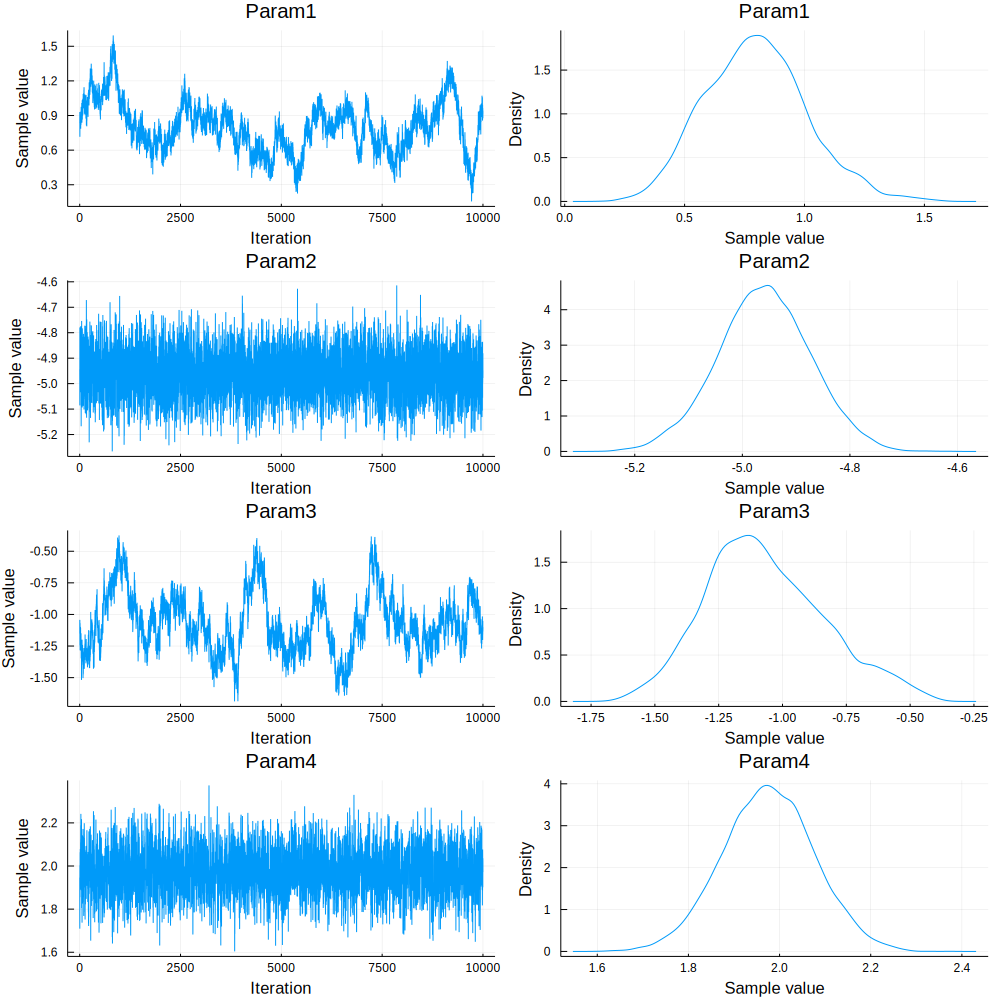

In [11]:
β_pos_sam = Array{Float64, 3}(undef, size(p1beta_samples)[1], p * q, 1);
β_pos_sam[:, :, 1] = hcat(p1beta_samples[:, 1], p1beta_samples[:, 2], 
    p2beta_samples[:, 1], p2beta_samples[:, 2]);
β_chain = Chains(β_pos_sam);
pβ = plot(β_chain)

In [12]:
β

2×2 Array{Float64,2}:
  1.0  -1.0
 -5.0   2.0

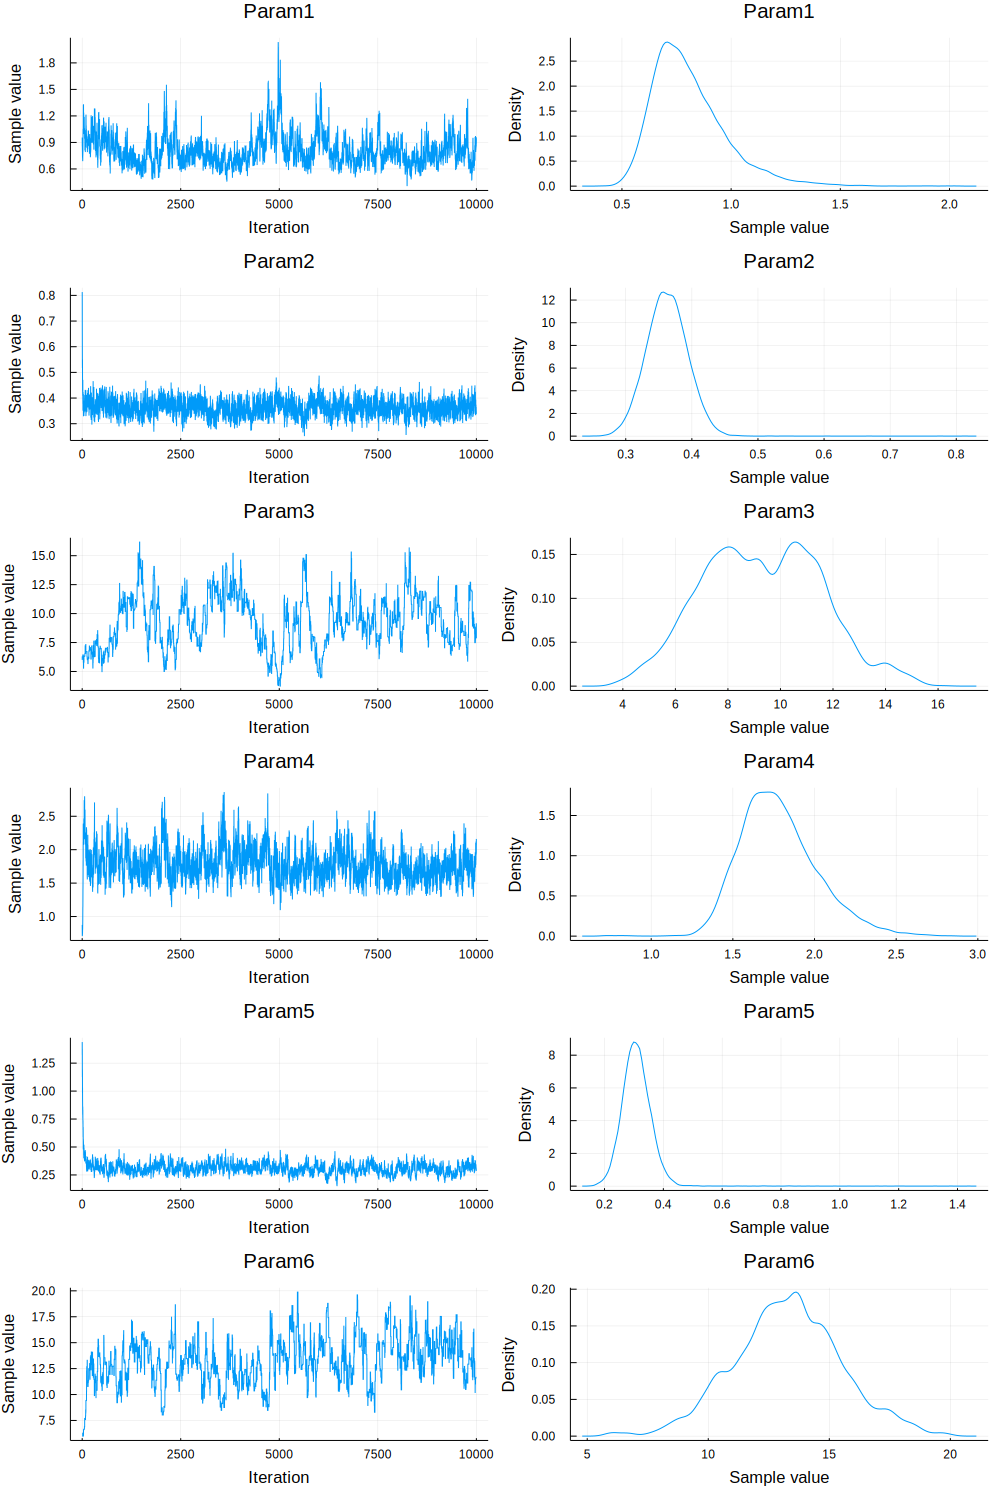

In [13]:
theta_pos_sam = Array{Float64, 3}(undef, size(p1theta_samples)[1], 6, 1);
theta_pos_sam[:, :, 1] = hcat(p1theta_samples[:, 1], p1theta_samples[:, 2], p1theta_samples[:, 3], 
    p2theta_samples[:, 1], p2theta_samples[:, 2], p2theta_samples[:, 3]);
theta_chain = Chains(theta_pos_sam);
ptheta = plot(theta_chain)

# Posterior Inference 

In [14]:
# CVG and RMSPE#
Nm = N - N1
count = fill(0.0, 2);
SPE = fill(0.0, 2)

for i in 1:Nm
    count[1] = count[1] + 
            ((yhat1[3, i] < Y_ord[P1_ind[i], 1]) && 
                (yhat1[4, i] > Y_ord[P1_ind[i], 1]));
    SPE[1] = SPE[1] + (yhat1[1, i] - Y_ord[P1_ind[i], 1])^2;
    count[2] = count[2] + 
            ((yhat2[3, i] < Y_ord[P2_ind[i], 2]) && 
                (yhat2[4, i] > Y_ord[P2_ind[i], 2]));
    SPE[2] = SPE[2] + (yhat2[1, i] - Y_ord[P2_ind[i], 2])^2;
end
print(count ./ 200);
print(sum(count) / 400);

[0.945, 0.96]0.9525

In [15]:
print(round.(sqrt.(SPE ./ 200), digits = 3));
print(round(sqrt(sum(SPE) / 400), digits = 3));

[0.733, 0.826]0.781

In [16]:
# CVGL latent process#
count = fill(0.0, 2);
SPEL = fill(0.0, 2)
for j in 1:q
    for i in 1:N1
        if j == 1
            count[1] = count[1] + 
                ((ω_qt[i, j, 1] < ω_ord[S1_ind[i], j]) && 
                (ω_qt[i, j, 3] > ω_ord[S1_ind[i], j]));
            SPEL[1] = SPEL[1] + (ω_mean[i, j] - ω_ord[S1_ind[i], j])^2;
        else
            count[2] = count[2] + 
                ((ω_qt[i, j, 1] < ω_ord[S2_ind[i], j]) && 
                (ω_qt[i, j, 3] > ω_ord[S2_ind[i], j]));
            SPEL[2] = SPEL[2] + (ω_mean[i, j] - ω_ord[S2_ind[i], j])^2;
        end
    end
    end                                   
print(round.(count ./ N, digits = 3));
print(round(sum(count) / (2*N), digits = 3))

[0.785, 0.814]0.8

In [17]:
# CVGL intercept-centered latent process#
count = fill(0.0, 2);
SPEL = fill(0.0, 2);
for i in 1:N1
    count[1] = count[1] + 
                ((ω1_incp_qt[i, 1] < ω_incp_obs[S1_ind[i], 1]) && 
                (ω1_incp_qt[i, 3] > ω_incp_obs[S1_ind[i], 1]));
    SPEL[1] = SPEL[1] + (ω1_incp_mean[i] - ω_incp_obs[S1_ind[i], 1])^2;
    count[2] = count[2] + 
                ((ω2_incp_qt[i, 1] < ω_incp_obs[S2_ind[i], 2]) && 
                (ω2_incp_qt[i, 3] > ω_incp_obs[S2_ind[i], 2]));
    SPEL[2] = SPEL[2] + (ω2_incp_mean[i] - ω_incp_obs[S2_ind[i], 2])^2;
end

print(round.(count ./ N, digits = 3));
print(round(sum(count) / (2*N), digits = 3))

[0.787, 0.798]0.792

In [18]:
# MSEL #
print(round.((SPEL ./ N1), digits = 3));
print(round((sum(SPEL) / (2 * N1)), digits = 3));

[0.139, 0.172]0.156

In [19]:
Y_P1_sam_std = (yhat1[4, :] .- yhat1[3, :]) ./ (2*1.96);
Y_P2_sam_std = (yhat2[4, :] .- yhat2[3, :]) ./ (2*1.96);

In [20]:
# CRPS #
CRPS_P1 = [(Y_P1_sam_std[i] * ( 1 /sqrt(π) - 
        2 * pdf(Normal(), (Y_ord[P1_ind[i], 1] - yhat1[1, i]) / Y_P1_sam_std[i]) -
        ((Y_ord[P1_ind[i], 1] - yhat1[1, i]) / Y_P1_sam_std[i]) * 
        (2* cdf(Normal(), (Y_ord[P1_ind[i], 1] - yhat1[1, i]) / Y_P1_sam_std[i]) - 1 )))
        for i in 1:length(P1_ind)];
CRPS_P2 = [(Y_P2_sam_std[i] * ( 1 /sqrt(π) - 
        2 * pdf(Normal(), (Y_ord[P2_ind[i], 2] - yhat2[1, i]) / Y_P2_sam_std[i]) -
        ((Y_ord[P2_ind[i], 2] - yhat2[1, i]) / Y_P2_sam_std[i]) * 
        (2* cdf(Normal(), (Y_ord[P2_ind[i], 2] - yhat2[1, i]) / Y_P2_sam_std[i]) - 1 )))
        for i in 1:length(P2_ind)];

CRPS1 = sum(CRPS_P1) / length(P1_ind);
CRPS2 = sum(CRPS_P2) / length(P2_ind);
CRPS = (sum(CRPS_P1) + sum(CRPS_P2)) / (length(P1_ind) + length(P2_ind))
round.([CRPS1 CRPS2 CRPS], digits = 3)

1×3 Array{Float64,2}:
 -0.415  -0.459  -0.437

In [21]:
ω1_incp_sam_std = [(ω1_incp_qt[i, 3] - ω1_incp_qt[i, 1]) ./ (2*1.96) for i in 1:1000];
ω2_incp_sam_std = [(ω2_incp_qt[i, 3] - ω2_incp_qt[i, 1]) ./ (2*1.96) for i in 1:1000];

In [22]:
# CRPSL over observed locations#

CRPSL_S1 = [(ω1_incp_sam_std[i] * ( 1 /sqrt(π) - 
        2 * pdf(Normal(), (ω_incp_obs[S1_ind[i], 1] - ω1_incp_mean[i]) / ω1_incp_sam_std[i]) -
        ((ω_incp_obs[S1_ind[i], 1] - ω1_incp_mean[i]) / ω1_incp_sam_std[i]) * 
        (2* cdf(Normal(), (ω_incp_obs[S1_ind[i], 1] - ω1_incp_mean[i]) / ω1_incp_sam_std[i]) - 1)))
        for i in 1:length(S1_ind)];

CRPSL_S2 = [(ω2_incp_sam_std[i] * ( 1 /sqrt(π) - 
        2 * pdf(Normal(), (ω_incp_obs[S2_ind[i], 2] - ω2_incp_mean[i]) / ω2_incp_sam_std[i]) -
        ((ω_incp_obs[S2_ind[i], 2] - ω2_incp_mean[i]) / ω2_incp_sam_std[i]) * 
        (2* cdf(Normal(), (ω_incp_obs[S2_ind[i], 2] - ω2_incp_mean[i]) / ω2_incp_sam_std[i]) - 1)))
        for i in 1:length(S2_ind)];


CRPSL1 = sum(CRPSL_S1) / length(S1_ind);
CRPSL2 = sum(CRPSL_S2) / length(S2_ind);
CRPSL = (sum(CRPSL_S1) + sum(CRPSL_S2)) / (length(S1_ind) + length(S2_ind))
round.([CRPSL1 CRPSL2 CRPSL], digits = 3)

1×3 Array{Float64,2}:
 -0.21  -0.235  -0.222

In [23]:
# INT #
INT_1 = [((2 * 1.96 * Y_P1_sam_std[i]) + 
                (2 / 0.05)*(yhat1[1, i] - 1.96 * Y_P1_sam_std[i] - Y_ord[P1_ind[i], 1]) * 
                (Y_ord[P1_ind[i], 1] < (yhat1[1, i] - 1.96 * Y_P1_sam_std[i])) + 
                (2 / 0.05)*(Y_ord[P1_ind[i], 1] - yhat1[1, i] - 1.96 * Y_P1_sam_std[i]) * 
                (Y_ord[P1_ind[i], 1] > (yhat1[1, i] + 
                1.96 * Y_P1_sam_std[i]))) for i in 1:length(P1_ind)];

INT_2 = [((2 * 1.96 * Y_P2_sam_std[i]) + 
                (2 / 0.05)*(yhat2[1, i] - 1.96 * Y_P2_sam_std[i] - Y_ord[P2_ind[i], 2]) * 
                (Y_ord[P2_ind[i], 2] < (yhat2[1, i] - 1.96 * Y_P2_sam_std[i])) + 
                (2 / 0.05)*(Y_ord[P2_ind[i], 2] - yhat2[1, i] - 1.96 * Y_P2_sam_std[i]) * 
                (Y_ord[P2_ind[i], 2] > (yhat2[1, i] + 
                1.96 * Y_P2_sam_std[i]))) for i in 1:length(P2_ind)];

INT1 = (sum(INT_1)) / (length(P1_ind));
INT2 = (sum(INT_2)) / (length(P2_ind));
INT = (sum(INT_1) + sum(INT_2))/(length(P1_ind) + (length(P2_ind)));

round.([INT1 INT2 INT], digits = 3)

1×3 Array{Float64,2}:
 3.396  4.083  3.739

In [24]:
# INTL #
INTL_1 = [((2 * 1.96 * ω1_incp_sam_std[i]) + 
        (2 / 0.05)*(ω1_incp_mean[i] - 1.96 * ω1_incp_sam_std[i] - 
            ω_incp_obs[S1_ind[i], 1]) * (ω_incp_obs[S1_ind[i], 1] < ( ω1_incp_mean[i] - 
                1.96 * ω1_incp_sam_std[i])) + (2 / 0.05)*(ω_incp_obs[S1_ind[i], 1] -  
            ω1_incp_mean[i] - 1.96 * ω1_incp_sam_std[i]) * 
        (ω_incp_obs[S1_ind[i], 1] > ( ω1_incp_mean[i] + 
                1.96 * ω1_incp_sam_std[i]))) for i in 1:length(S1_ind)];

INTL_2 = [((2 * 1.96 * ω2_incp_sam_std[i]) + 
        (2 / 0.05)*(ω2_incp_mean[i] - 1.96 * ω2_incp_sam_std[i] - 
            ω_incp_obs[S2_ind[i], 2]) * (ω_incp_obs[S2_ind[i], 2] < ( ω2_incp_mean[i] - 
                1.96 * ω2_incp_sam_std[i])) + (2 / 0.05)*(ω_incp_obs[S2_ind[i], 2] -  
            ω2_incp_mean[i] - 1.96 * ω2_incp_sam_std[i]) * 
        (ω_incp_obs[S2_ind[i], 2] > ( ω2_incp_mean[i] + 
                1.96 * ω2_incp_sam_std[i]))) for i in 1:length(S2_ind)];


INTL1 = sum(INTL_1) / length(S1_ind);
INTL2 = sum(INTL_2) / length(S2_ind);
INTL = (sum(INTL_1) + sum(INTL_2))/(length(S1_ind) + length(S2_ind));

round.([INTL1 INTL2 INTL], digits = 3)

1×3 Array{Float64,2}:
 1.75  1.917  1.834

In [25]:
covω = cov(ω_ord[S, :])

2×2 Array{Float64,2}:
 0.683048  0.726177
 0.726177  1.78576 

In [26]:
using RCall

In [28]:
# ESS-slope #
ESS_slope = fill(0.0, p, q)
MCSE_slope = fill(0.0, p, q)
Rhat_slope = fill(0.0, p, q)
for i in 1:p
    ESS_slope[i, 1] = effective_sample_size(p1beta_samples[N_pre_burn:N_sam, i]);
    
    MCMCsample = p1beta_samples[N_pre_burn:N_sam, i];  
    @rput MCMCsample
    R"""
    library(mcmcse)
    mcse1 = mcse(MCMCsample, size = 50)$se
    """
    @rget mcse1
    MCSE_slope[i, 1] = mcse1
    
    #MCSE_slope[i, 1] = std(p1beta_samples[N_pre_burn:N_sam, i]) / 
    #        sqrt(ESS_slope[i, 1]);
    Rhat_slope[i, 1] = potential_scale_reduction(
            p1beta_samples[N_pre_burn:N_sam, i][1:2500], 
        p1beta_samples[N_pre_burn:N_sam, i][2501:5000])
    
    ESS_slope[i, 2] = effective_sample_size(p2beta_samples[N_pre_burn:N_sam, i]);

    MCMCsample = p2beta_samples[N_pre_burn:N_sam, i];
    @rput MCMCsample
    R"""
    library(mcmcse)
    mcse1 = mcse(MCMCsample, size = 50)$se
    """
    @rget mcse1
    MCSE_slope[i, 2] = mcse1
    #MCSE_slope[i, 2] = std(p2beta_samples[N_pre_burn:N_sam, i]) / 
    #        sqrt(ESS_slope[i, 2]);
    Rhat_slope[i, 2] = potential_scale_reduction(
            p2beta_samples[N_pre_burn:N_sam, i][1:2500], p2beta_samples[N_pre_burn:N_sam, i][2501:5000])
end   
[ESS_slope, MCSE_slope, Rhat_slope]

┌ Warning: RCall.jl: mcmcse: Monte Carlo Standard Errors for MCMC
│ Version 1.4-1 created on 2020-01-29.
│ copyright (c) 2012, James M. Flegal, University of California, Riverside
│                     John Hughes, University of Colorado, Denver
│                     Dootika Vats, University of Warwick
│                     Ning Dai, University of Minnesota
│  For citation information, type citation("mcmcse").
│  Type help("mcmcse-package") to get started.
│ 
└ @ RCall /home/lu/.julia/packages/RCall/g7dhB/src/io.jl:113


3-element Array{Array{Float64,2},1}:
 [14.59563163058103 14.16311822721968; 1422.1458630800407 875.1821950442194]            
 [0.025495571598105393 0.026724070927247132; 0.002525317353549315 0.0036748980454200577]
 [1.0057392531421714 1.0094106336560111; 1.0039800007452533 1.000000299827421]          

In [29]:
# ESS-ϕ #
ESS_ϕ = fill(0.0, q)
MCSE_ϕ = fill(0.0, q)
Rhat_ϕ = fill(0.0, q)

ESS_ϕ[1] = effective_sample_size(p1theta_samples[N_pre_burn:N_sam, 3]);
MCMCsample = p1theta_samples[N_pre_burn:N_sam, 3];  
@rput MCMCsample
R"""
library(mcmcse)
mcse1 = mcse(MCMCsample, size = 50)$se
"""
@rget mcse1
MCSE_ϕ[1] = mcse1
#MCSE_ϕ[1] = std(p1theta_samples[N_pre_burn:N_sam, 3]) / sqrt(ESS_ϕ[1]);
Rhat_ϕ[1] = potential_scale_reduction(
        p1theta_samples[N_pre_burn:N_sam, 3][1:2500], 
    p1theta_samples[N_pre_burn:N_sam, 3][2501:5000]);

ESS_ϕ[2] = effective_sample_size(p2theta_samples[N_pre_burn:N_sam, 3]);
MCMCsample = p2theta_samples[N_pre_burn:N_sam, 3];  
@rput MCMCsample
R"""
library(mcmcse)
mcse1 = mcse(MCMCsample, size = 50)$se
"""
@rget mcse1
MCSE_ϕ[2] = mcse1
#MCSE_ϕ[2] = std(p2theta_samples[N_pre_burn:N_sam, 3]) / sqrt(ESS_ϕ[2]);
Rhat_ϕ[2] = potential_scale_reduction(
        p2theta_samples[N_pre_burn:N_sam, 3][1:2500], 
    p2theta_samples[N_pre_burn:N_sam, 3][2501:5000]);


[ESS_ϕ, MCSE_ϕ, Rhat_ϕ]

3-element Array{Array{Float64,1},1}:
 [30.746179483589685, 47.072503455841336]
 [0.246826491846372, 0.2258794300543032] 
 [1.0323652032454764, 1.0282671942187223]

In [30]:
# ESS-Σ #
ESS_Σ = fill(0.0, q)
MCSE_Σ = fill(0.0, q)
Rhat_Σ = fill(0.0, q)

ESS_Σ[1] = effective_sample_size(p1theta_samples[N_pre_burn:N_sam, 2]);
MCMCsample = p1theta_samples[N_pre_burn:N_sam, 2];  
@rput MCMCsample
R"""
library(mcmcse)
mcse1 = mcse(MCMCsample, size = 50)$se
"""
@rget mcse1
MCSE_Σ[1] = mcse1
#MCSE_Σ[1] = std(p1theta_samples[N_pre_burn:N_sam, 2]) / sqrt(ESS_ϕ[1]);
Rhat_Σ[1] = potential_scale_reduction(
        p1theta_samples[N_pre_burn:N_sam, 2][1:2500], 
    p1theta_samples[N_pre_burn:N_sam, 2][2501:5000]);

ESS_Σ[2] = effective_sample_size(p2theta_samples[N_pre_burn:N_sam, 2]);
MCMCsample = p2theta_samples[N_pre_burn:N_sam, 2];  
@rput MCMCsample
R"""
library(mcmcse)
mcse1 = mcse(MCMCsample, size = 50)$se
"""
@rget mcse1
MCSE_Σ[2] = mcse1
#MCSE_Σ[2] = std(p2theta_samples[N_pre_burn:N_sam, 2]) / sqrt(ESS_ϕ[2]);
Rhat_Σ[2] = potential_scale_reduction(
        p2theta_samples[N_pre_burn:N_sam, 2][1:2500], 
    p2theta_samples[N_pre_burn:N_sam, 2][2501:5000]);

[ESS_Σ, MCSE_Σ, Rhat_Σ]

3-element Array{Array{Float64,1},1}:
 [201.0169343323092, 93.0139716190702]        
 [0.0019768282712404658, 0.003825120860422227]
 [1.0037266098262843, 1.0008469263474418]     

In [31]:
summary_table = Array{Float64, 2}(undef, 8, 8);
summary_table[1, :] = vcat(β[1, 1], mean(p1beta_samples[N_pre_burn:N_sam, 1]),
    quantile(p1beta_samples[N_pre_burn:N_sam, 1], [0.5, 0.025, 0.975]), 
    ESS_slope[1, 1], MCSE_slope[1, 1], Rhat_slope[1, 1]);
summary_table[2, :] = vcat(β[1, 2], mean(p2beta_samples[N_pre_burn:N_sam, 1]),
    quantile(p2beta_samples[N_pre_burn:N_sam, 1], [0.5, 0.025, 0.975]), 
    ESS_slope[1, 2], MCSE_slope[1, 2], Rhat_slope[1, 2]);
summary_table[3, :] = vcat(β[2, 1], mean(p1beta_samples[N_pre_burn:N_sam, 2]),
    quantile(p1beta_samples[N_pre_burn:N_sam, 2], [0.5, 0.025, 0.975]), 
    ESS_slope[2, 1], MCSE_slope[2, 1], Rhat_slope[2, 1]);
summary_table[4, :] = vcat(β[2, 2], mean(p2beta_samples[N_pre_burn:N_sam, 2]),
    quantile(p2beta_samples[N_pre_burn:N_sam, 2], [0.5, 0.025, 0.975]), 
    ESS_slope[2, 2], MCSE_slope[2, 2], Rhat_slope[2, 2]);
summary_table[5, :] = vcat(Σ[1, 1], mean(p1theta_samples[N_pre_burn:N_sam, 2]),
    quantile(p1theta_samples[N_pre_burn:N_sam, 2], [0.5, 0.025, 0.975]), 
            ESS_Σ[1], MCSE_Σ[1], Rhat_Σ[1]);
summary_table[6, :] = vcat(Σ[2, 2], mean(p2theta_samples[N_pre_burn:N_sam, 2]),
    quantile(p2theta_samples[N_pre_burn:N_sam, 2], [0.5, 0.025, 0.975]), 
                ESS_Σ[2], MCSE_Σ[2], Rhat_Σ[2]);
summary_table[7, :] = vcat(ϕ1, mean(p1theta_samples[N_pre_burn:N_sam, 3]),
    quantile(p1theta_samples[N_pre_burn:N_sam, 3], [0.5, 0.025, 0.975]), 
                ESS_ϕ[1], MCSE_ϕ[1], Rhat_ϕ[1]);
summary_table[8, :] = vcat(ϕ2, mean(p2theta_samples[N_pre_burn:N_sam, 3]),
    quantile(p2theta_samples[N_pre_burn:N_sam, 3], [0.5, 0.025, 0.975]), 
                ESS_ϕ[2], MCSE_ϕ[2], Rhat_ϕ[2]);
summary_table = round.(summary_table; digits = 3);
rnames = ["β[1, 1]", "β[1, 2]", "β[2, 1]", "β[2, 2]", "Σ[1, 1]", "Σ[2, 2]", "ϕ1", "ϕ2"];
summary_table = [rnames summary_table];
pretty_table(summary_table,  ["" "true" "mean" "median" "2.5%" "97.5%" "ESS" "MCSE" "Rhat"], markdown)

|         | true |   mean | median |   2.5% |  97.5% |      ESS |  MCSE |  Rha ⋯
|---------|------|--------|--------|--------|--------|----------|-------|----- ⋯
| β[1, 1] |  1.0 |  0.764 |  0.775 |  0.372 |  1.199 |   14.596 | 0.025 | 1.00 ⋯
| β[1, 2] | -1.0 | -1.101 | -1.117 | -1.511 | -0.596 |   14.163 | 0.027 | 1.00 ⋯
| β[2, 1] | -5.0 |  -4.96 | -4.959 | -5.133 | -4.795 | 1422.146 | 0.003 | 1.00 ⋯
| β[2, 2] |  2.0 |  1.975 |  1.974 |  1.777 |  2.168 |  875.182 | 0.004 |   1. ⋯
| Σ[1, 1] |  0.4 |  0.361 |  0.361 |  0.303 |  0.421 |  201.017 | 0.002 | 1.00 ⋯
| Σ[2, 2] |  0.3 |  0.299 |  0.299 |  0.208 |  0.392 |   93.014 | 0.004 | 1.00 ⋯
|      ϕ1 |  6.0 |  9.393 |  9.274 |  4.906 | 13.976 |   30.746 | 0.247 | 1.03 ⋯
|      ϕ2 | 18.0 | 14.086 | 13.969 | 10.114 | 18.366 |   47.073 | 0.226 | 1.02 ⋯


In [32]:
pretty_table(summary_table[:, [1, 2, 7, 8, 9]],  ["" "true" "ESS" "MCSE" "Rhat"], markdown)

|         | true |      ESS |  MCSE |  Rhat |
|---------|------|----------|-------|-------|
| β[1, 1] |  1.0 |   14.596 | 0.025 | 1.006 |
| β[1, 2] | -1.0 |   14.163 | 0.027 | 1.009 |
| β[2, 1] | -5.0 | 1422.146 | 0.003 | 1.004 |
| β[2, 2] |  2.0 |  875.182 | 0.004 |   1.0 |
| Σ[1, 1] |  0.4 |  201.017 | 0.002 | 1.004 |
| Σ[2, 2] |  0.3 |   93.014 | 0.004 | 1.001 |
|      ϕ1 |  6.0 |   30.746 | 0.247 | 1.032 |
|      ϕ2 | 18.0 |   47.073 | 0.226 | 1.028 |
